# CREATE A COPY FIRST!

## **Question 2: Arabic Handwritten Character Search**

Ali’s younger brother is learning to write Arabic characters. One day, he wrote a character that looks like **"ب"**, and Ali wants to find **the most similar 5 images** from a dataset of handwritten Arabic characters.

📝 **Your Task:**  
Complete the missing code cells below by implementing **image search** to find the most similar 5 images to the given input character.  



# Download Data

### Query Image

In [1]:
# # Please uncomment this out when you are running this lab on google colab!
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [35]:
import kagglehub
from PIL import Image
import os

path = kagglehub.dataset_download("mohammad2012191/character")
raw_query_image = Image.open(os.path.join(path,"char.png"))

print(path)

/content/data/datasets/mohammad2012191/character/versions/5


### Arabic Characters Dataset

In [6]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("mohammad2012191/arabic-chars")

print("Path to dataset files:", dataset_path)

100%|██████████| 219k/219k [00:00<00:00, 494kB/s]

Extracting files...
Path to dataset files: /content/data/datasets/mohammad2012191/arabic-chars/versions/3


# TASK 1: Complete the following code to build a custom dataset class for the data

In [12]:
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ArabicHandwritingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = glob.glob(f"{root_dir}/*.png") #TO DO: Use glob to extract images paths from root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path) #TO DO: Write a line to load the image from img_path
        label = int(img_path.split("/")[-1].split("_")[-1].split(".")[0]) #TO DO: Write a line to extract the label from img_path
        if self.transform:
            image = self.transform(image)
        return image, label

In [47]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((32, 32)), # Resize images: Resize to 32*32
    transforms.ToTensor(),# TO DO: Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



train_dataset = ArabicHandwritingDataset(root_dir=os.path.join(dataset_path,"chars images"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
print(f"Total images: {len(train_dataset)}")



transformed_query_image =  transform(raw_query_image)   #TO DO: Apply the transform to raw_query_image

Total images: 668


# TASK 2: Use EfficientNet B3 to extract features.

##### import using:
from torchvision.models import efficientnet_b3

### Extract Features for the dataset images

In [40]:
from torchvision.models import efficientnet_b3

import torch
import torchvision.models as models
from torch import nn
from tqdm import tqdm

# Load pretrained EfficientNetV2-S model
device = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

efficientnet.eval().to(device)

# Modify EfficientNetB3to extract features before classification
def extract_features(image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        features = efficientnet.features(image_tensor)  # Extract features
        features = torch.flatten(features, start_dim=1)  # Flatten before passing to classifier
        # features = efficientnet.classifier[0](features)  # Pass through first layer of classifier
    return features

# Extract features for all images
all_features = []
image_tensors = []

for images, _ in tqdm(train_loader):
    image_tensors.append(images)

    features = extract_features(images)
    all_features.append(features.cpu())

100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


### Extract Features for the query image

In [48]:
### TO DO: Fix the error in this line so it extracts features from the query image successfully

transformed_query_image = transformed_query_image.unsqueeze(0)
print(transformed_query_image.shape)
query_image_feats = extract_features(transformed_query_image)

torch.Size([1, 3, 32, 32])


# TASK 3: Get the indices of top 5 images using Cosine Similarity

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# Convet to numpy because Cosine similarity import accepts numpy
all_features = torch.cat(all_features).numpy()
image_tensors = torch.cat(image_tensors)
query_image_feats = query_image_feats.numpy()

similarities = cosine_similarity(all_features, query_image_feats.reshape(1, -1)).reshape(-1)

# Get top 5 similar images
top_indices = similarities.argsort()[-6:-1][::-1]  # Ignore query itself







# TASK 4: Fix the errors in the following code to plot the most 5 similar images

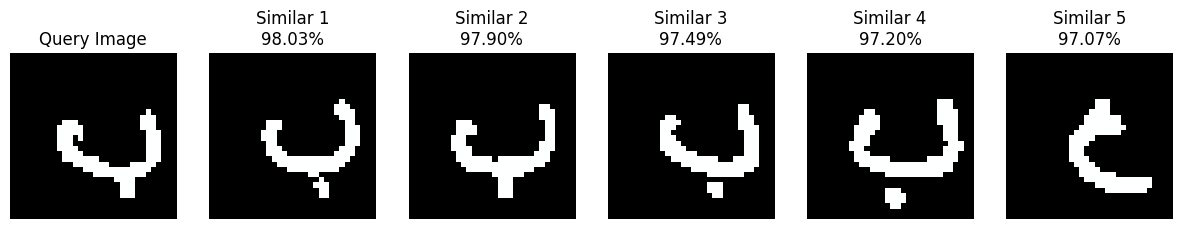

In [50]:
import numpy as np
# Display query & retrieved images with similarity scores

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img


# Query image
axes[0].imshow(denormalize(transformed_query_image.squeeze(0)))
axes[0].set_title("Query Image")
axes[0].axis("off")

# Retrieved similar images with similarity scores
for i, idx in enumerate(top_indices):
    image = image_tensors[idx]
    similarity_score = similarities[idx]  # Get similarity score
    axes[i + 1].imshow(denormalize(image))
    axes[i + 1].set_title(f"Similar {i+1}\n{100*similarity_score:.2f}%")  # Show similarity score
    axes[i + 1].axis("off")

plt.show()


# Bonus Task:  Get the indices of the most 5 *dissimilar* images and plot them

In [ ]:
### TO DO